# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides=2):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    small_ip_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([small_ip_layer, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters, 1)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, 1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    e1 = encoder_block(inputs, 32) #128 -> 64
    e2 = encoder_block(e1,     64) # 64 -> 32
    e3 = encoder_block(e2,     128) # 32 -> 16
    #e4 = encoder_block(e3,    256) # 16 ->  8

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    neck = conv2d_batchnorm(e3, 256, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #x4 = decoder_block(neck, e3,  256) #  8 ->  16
    x3 = decoder_block(neck, e2,     128) # 16 ->  32
    x2 = decoder_block(x3, e1,     64) # 32 ->  64 
    x  = decoder_block(x2, inputs, 32) # 64 -> 128
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = .001
num_epochs = 120
batch_size = 32
steps_per_epoch = 128
validation_steps = 8
workers = 4

Epoch 1/120
127/128 [============================>.] - ETA: 0s - loss: 0.7106

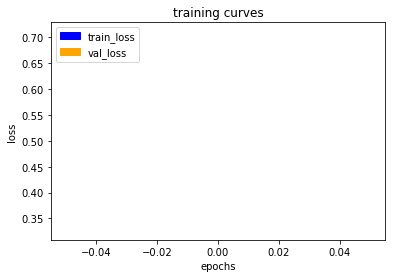

128/128 [==============================] - 76s - loss: 0.7072 - val_loss: 0.3279
Epoch 2/120
127/128 [============================>.] - ETA: 0s - loss: 0.1420

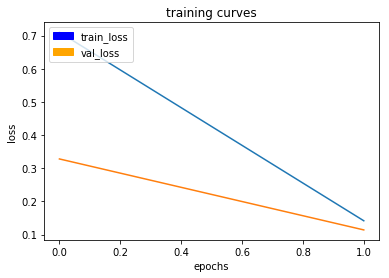

128/128 [==============================] - 73s - loss: 0.1415 - val_loss: 0.1140
Epoch 3/120
127/128 [============================>.] - ETA: 0s - loss: 0.0716

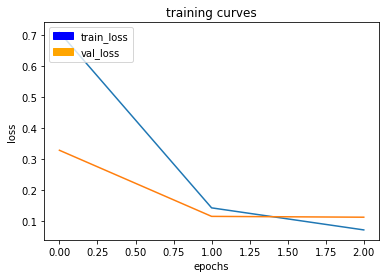

128/128 [==============================] - 72s - loss: 0.0717 - val_loss: 0.1113
Epoch 4/120
127/128 [============================>.] - ETA: 0s - loss: 0.0527

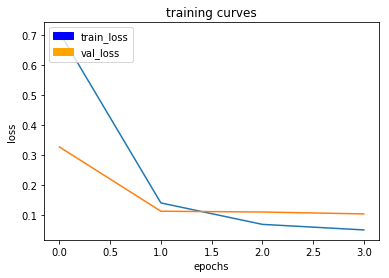

128/128 [==============================] - 72s - loss: 0.0528 - val_loss: 0.1049
Epoch 5/120
127/128 [============================>.] - ETA: 0s - loss: 0.0425

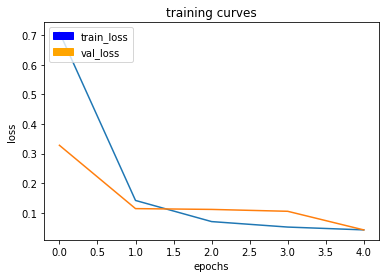

128/128 [==============================] - 72s - loss: 0.0424 - val_loss: 0.0420
Epoch 6/120
127/128 [============================>.] - ETA: 0s - loss: 0.0382

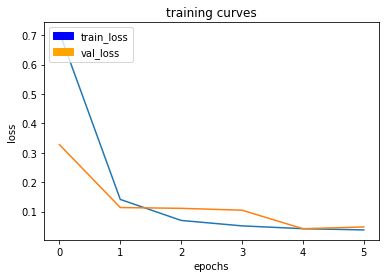

128/128 [==============================] - 72s - loss: 0.0382 - val_loss: 0.0480
Epoch 7/120
127/128 [============================>.] - ETA: 0s - loss: 0.0338

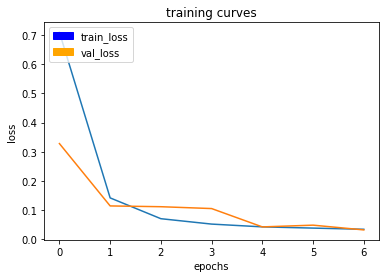

128/128 [==============================] - 72s - loss: 0.0338 - val_loss: 0.0316
Epoch 8/120
127/128 [============================>.] - ETA: 0s - loss: 0.0320

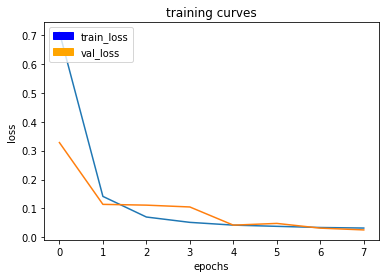

128/128 [==============================] - 73s - loss: 0.0320 - val_loss: 0.0255
Epoch 9/120
127/128 [============================>.] - ETA: 0s - loss: 0.0294

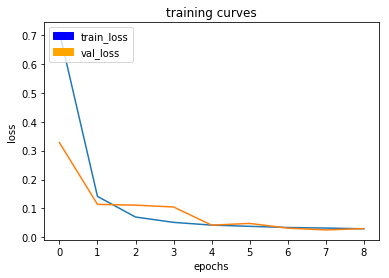

128/128 [==============================] - 73s - loss: 0.0293 - val_loss: 0.0299
Epoch 10/120
127/128 [============================>.] - ETA: 0s - loss: 0.0305

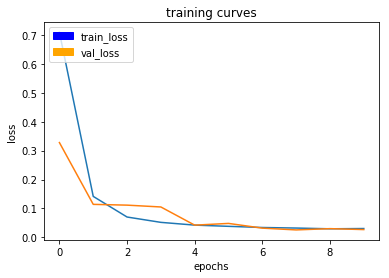

128/128 [==============================] - 72s - loss: 0.0304 - val_loss: 0.0267
Epoch 11/120
127/128 [============================>.] - ETA: 0s - loss: 0.0328

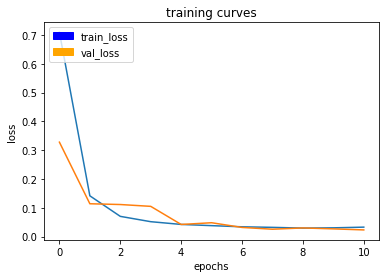

128/128 [==============================] - 72s - loss: 0.0327 - val_loss: 0.0230
Epoch 12/120
127/128 [============================>.] - ETA: 0s - loss: 0.0282

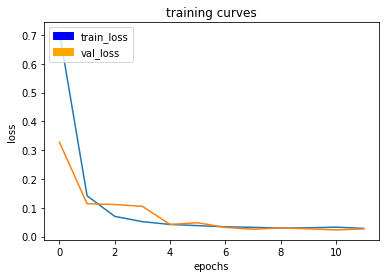

128/128 [==============================] - 72s - loss: 0.0283 - val_loss: 0.0267
Epoch 13/120
127/128 [============================>.] - ETA: 0s - loss: 0.0257

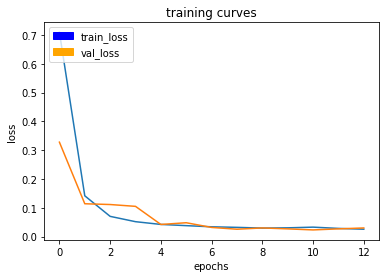

128/128 [==============================] - 72s - loss: 0.0256 - val_loss: 0.0299
Epoch 14/120
127/128 [============================>.] - ETA: 0s - loss: 0.0256

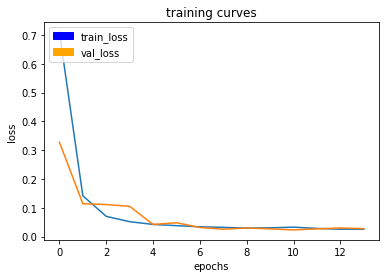

128/128 [==============================] - 72s - loss: 0.0256 - val_loss: 0.0274
Epoch 15/120
127/128 [============================>.] - ETA: 0s - loss: 0.0245

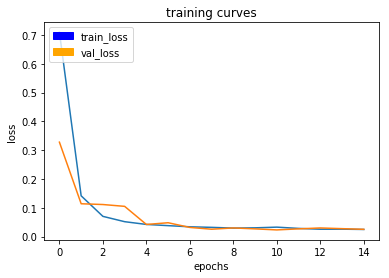

128/128 [==============================] - 72s - loss: 0.0246 - val_loss: 0.0251
Epoch 16/120
127/128 [============================>.] - ETA: 0s - loss: 0.0233

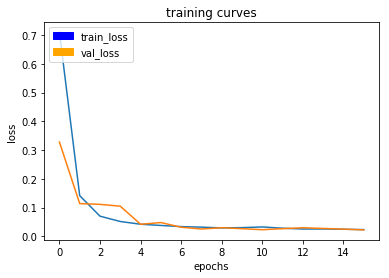

128/128 [==============================] - 72s - loss: 0.0234 - val_loss: 0.0223
Epoch 17/120
127/128 [============================>.] - ETA: 0s - loss: 0.0233

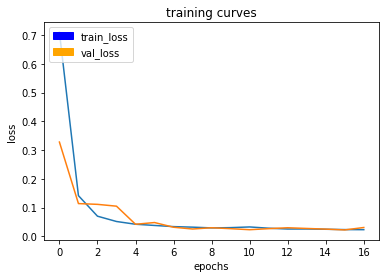

128/128 [==============================] - 72s - loss: 0.0233 - val_loss: 0.0307
Epoch 18/120
127/128 [============================>.] - ETA: 0s - loss: 0.0234

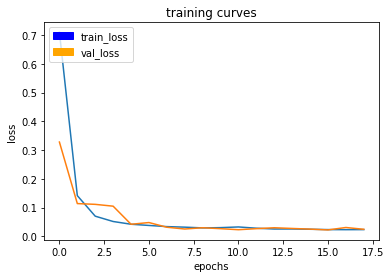

128/128 [==============================] - 72s - loss: 0.0234 - val_loss: 0.0246
Epoch 19/120
127/128 [============================>.] - ETA: 0s - loss: 0.0225

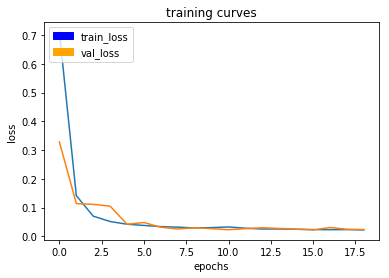

128/128 [==============================] - 72s - loss: 0.0224 - val_loss: 0.0235
Epoch 20/120
127/128 [============================>.] - ETA: 0s - loss: 0.0214

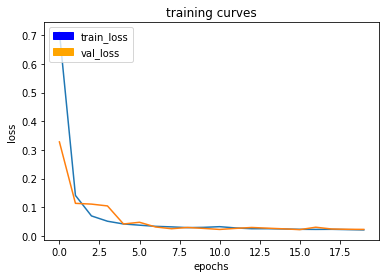

128/128 [==============================] - 72s - loss: 0.0214 - val_loss: 0.0232
Epoch 21/120
127/128 [============================>.] - ETA: 0s - loss: 0.0210

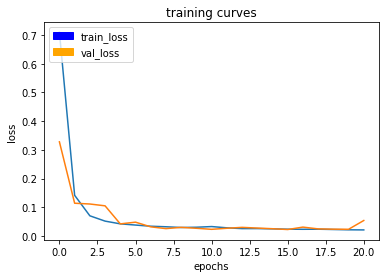

128/128 [==============================] - 72s - loss: 0.0210 - val_loss: 0.0538
Epoch 22/120
127/128 [============================>.] - ETA: 0s - loss: 0.0197

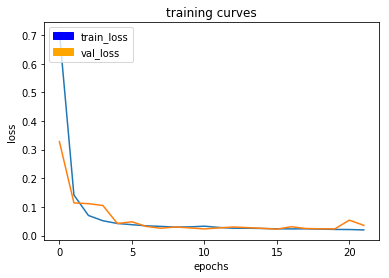

128/128 [==============================] - 72s - loss: 0.0197 - val_loss: 0.0355
Epoch 23/120
127/128 [============================>.] - ETA: 0s - loss: 0.0192

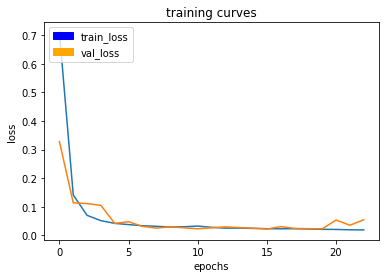

128/128 [==============================] - 72s - loss: 0.0192 - val_loss: 0.0550
Epoch 24/120
127/128 [============================>.] - ETA: 0s - loss: 0.0198

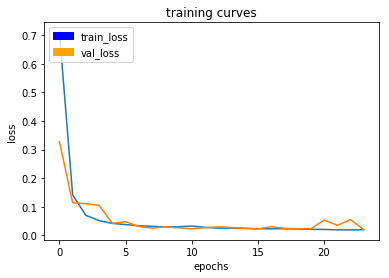

128/128 [==============================] - 73s - loss: 0.0198 - val_loss: 0.0200
Epoch 25/120
127/128 [============================>.] - ETA: 0s - loss: 0.0198

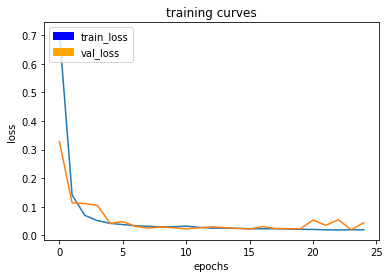

128/128 [==============================] - 72s - loss: 0.0198 - val_loss: 0.0444
Epoch 26/120
127/128 [============================>.] - ETA: 0s - loss: 0.0175

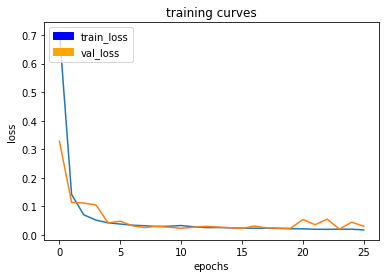

128/128 [==============================] - 72s - loss: 0.0175 - val_loss: 0.0302
Epoch 27/120
127/128 [============================>.] - ETA: 0s - loss: 0.0190

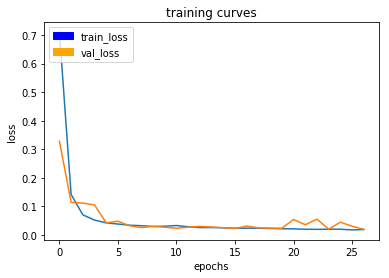

128/128 [==============================] - 72s - loss: 0.0189 - val_loss: 0.0193
Epoch 28/120
127/128 [============================>.] - ETA: 0s - loss: 0.0197

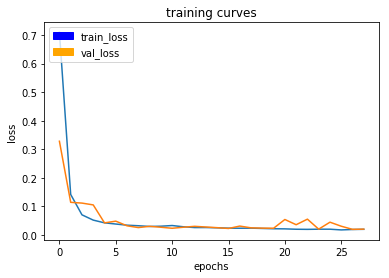

128/128 [==============================] - 72s - loss: 0.0196 - val_loss: 0.0200
Epoch 29/120
127/128 [============================>.] - ETA: 0s - loss: 0.0186

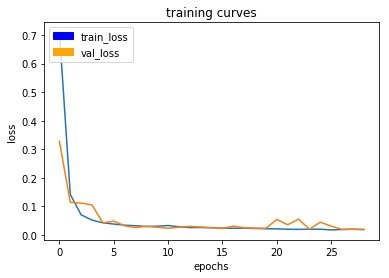

128/128 [==============================] - 72s - loss: 0.0186 - val_loss: 0.0189
Epoch 30/120
127/128 [============================>.] - ETA: 0s - loss: 0.0190

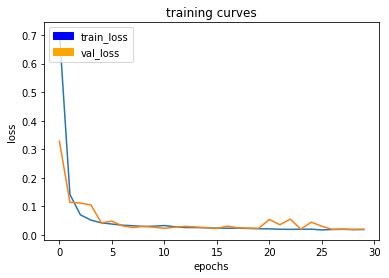

128/128 [==============================] - 72s - loss: 0.0190 - val_loss: 0.0196
Epoch 31/120
127/128 [============================>.] - ETA: 0s - loss: 0.0186

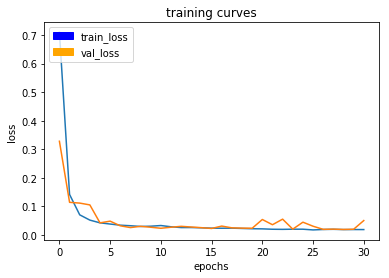

128/128 [==============================] - 72s - loss: 0.0186 - val_loss: 0.0501
Epoch 32/120
127/128 [============================>.] - ETA: 0s - loss: 0.0163

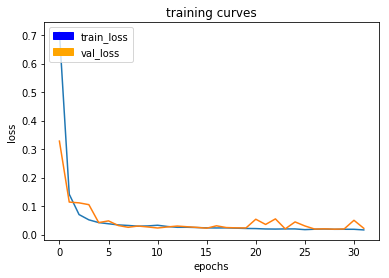

128/128 [==============================] - 72s - loss: 0.0163 - val_loss: 0.0220
Epoch 33/120
127/128 [============================>.] - ETA: 0s - loss: 0.0180

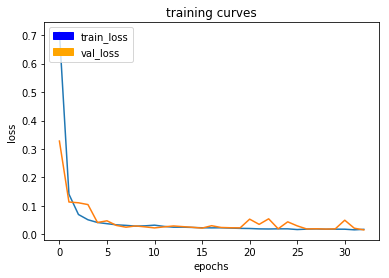

128/128 [==============================] - 72s - loss: 0.0180 - val_loss: 0.0160
Epoch 34/120
127/128 [============================>.] - ETA: 0s - loss: 0.0173

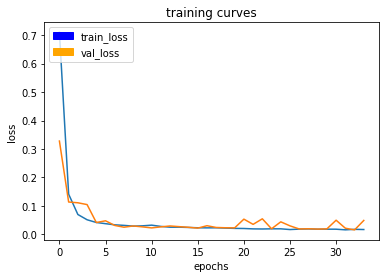

128/128 [==============================] - 72s - loss: 0.0173 - val_loss: 0.0492
Epoch 35/120
127/128 [============================>.] - ETA: 0s - loss: 0.0149

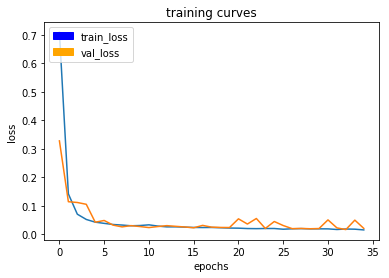

128/128 [==============================] - 72s - loss: 0.0149 - val_loss: 0.0202
Epoch 36/120
127/128 [============================>.] - ETA: 0s - loss: 0.0160

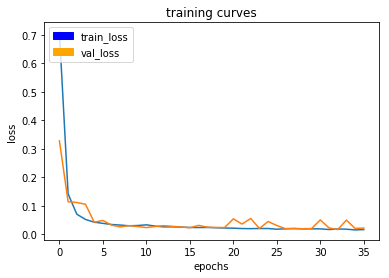

128/128 [==============================] - 73s - loss: 0.0160 - val_loss: 0.0213
Epoch 37/120
127/128 [============================>.] - ETA: 0s - loss: 0.0177

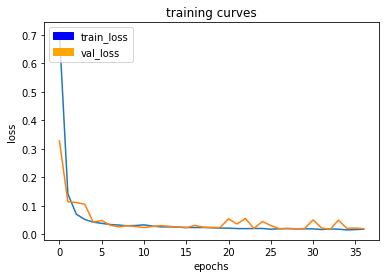

128/128 [==============================] - 72s - loss: 0.0177 - val_loss: 0.0190
Epoch 38/120
127/128 [============================>.] - ETA: 0s - loss: 0.0169

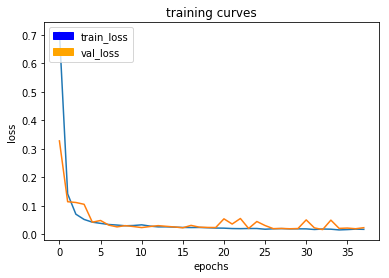

128/128 [==============================] - 72s - loss: 0.0169 - val_loss: 0.0227
Epoch 39/120
127/128 [============================>.] - ETA: 0s - loss: 0.0151

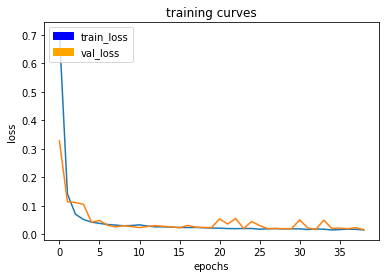

128/128 [==============================] - 73s - loss: 0.0151 - val_loss: 0.0159
Epoch 40/120
127/128 [============================>.] - ETA: 0s - loss: 0.0162

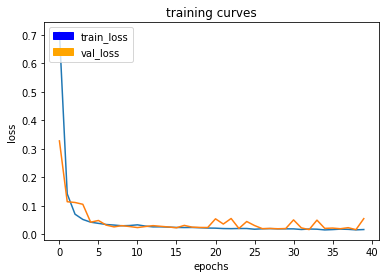

128/128 [==============================] - 73s - loss: 0.0162 - val_loss: 0.0545
Epoch 41/120
127/128 [============================>.] - ETA: 0s - loss: 0.0144

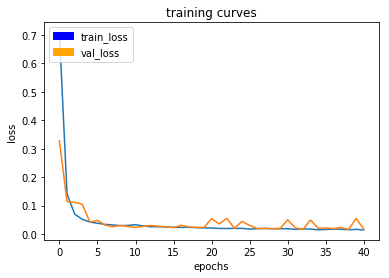

128/128 [==============================] - 73s - loss: 0.0144 - val_loss: 0.0172
Epoch 42/120
127/128 [============================>.] - ETA: 0s - loss: 0.0143

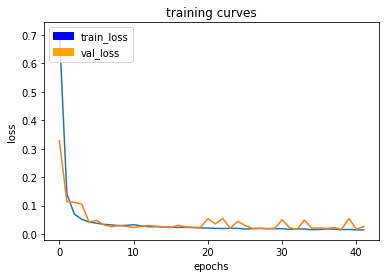

128/128 [==============================] - 72s - loss: 0.0143 - val_loss: 0.0260
Epoch 43/120
127/128 [============================>.] - ETA: 0s - loss: 0.0158

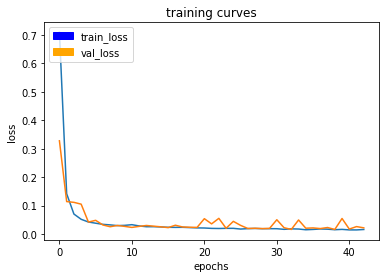

128/128 [==============================] - 72s - loss: 0.0158 - val_loss: 0.0215
Epoch 44/120
127/128 [============================>.] - ETA: 0s - loss: 0.0137

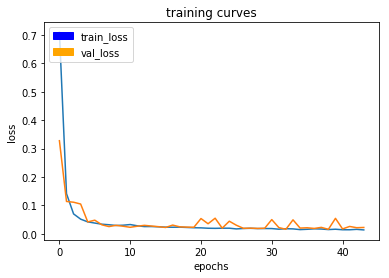

128/128 [==============================] - 72s - loss: 0.0137 - val_loss: 0.0224
Epoch 45/120
127/128 [============================>.] - ETA: 0s - loss: 0.0156

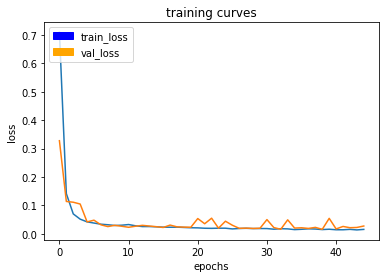

128/128 [==============================] - 72s - loss: 0.0156 - val_loss: 0.0275
Epoch 46/120
127/128 [============================>.] - ETA: 0s - loss: 0.0134

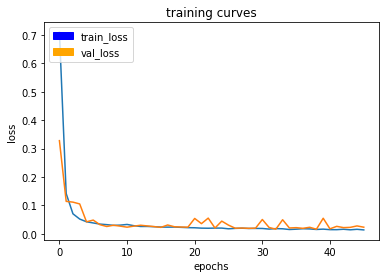

128/128 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0229
Epoch 47/120
127/128 [============================>.] - ETA: 0s - loss: 0.0149

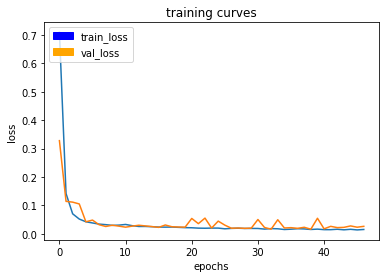

128/128 [==============================] - 72s - loss: 0.0150 - val_loss: 0.0260
Epoch 48/120
127/128 [============================>.] - ETA: 0s - loss: 0.0142

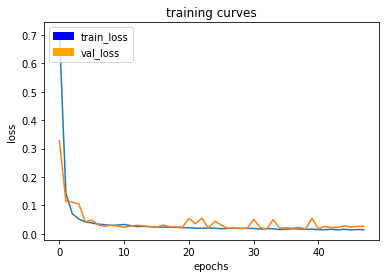

128/128 [==============================] - 72s - loss: 0.0141 - val_loss: 0.0262
Epoch 49/120
127/128 [============================>.] - ETA: 0s - loss: 0.0126

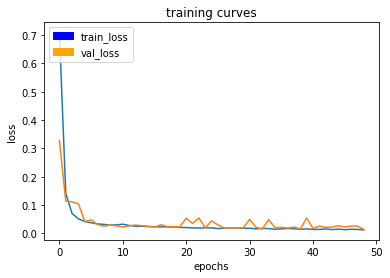

128/128 [==============================] - 72s - loss: 0.0126 - val_loss: 0.0143
Epoch 50/120
127/128 [============================>.] - ETA: 0s - loss: 0.0151

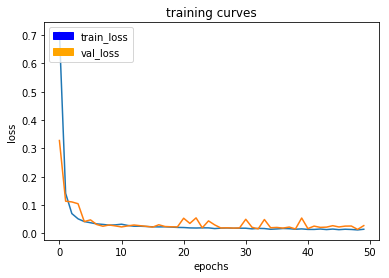

128/128 [==============================] - 72s - loss: 0.0151 - val_loss: 0.0277
Epoch 51/120
127/128 [============================>.] - ETA: 0s - loss: 0.0164

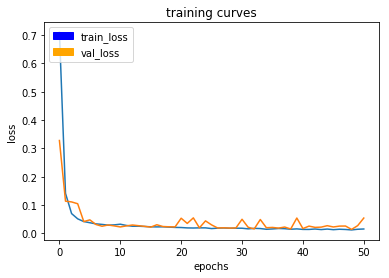

128/128 [==============================] - 72s - loss: 0.0164 - val_loss: 0.0544
Epoch 52/120
127/128 [============================>.] - ETA: 0s - loss: 0.0152

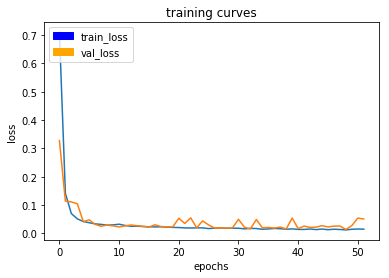

128/128 [==============================] - 72s - loss: 0.0151 - val_loss: 0.0509
Epoch 53/120
127/128 [============================>.] - ETA: 0s - loss: 0.0135

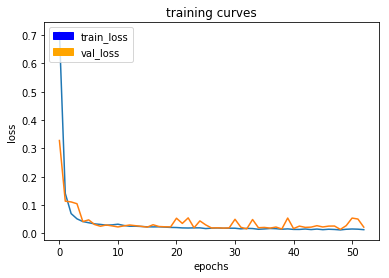

128/128 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0223
Epoch 54/120
127/128 [============================>.] - ETA: 0s - loss: 0.0135

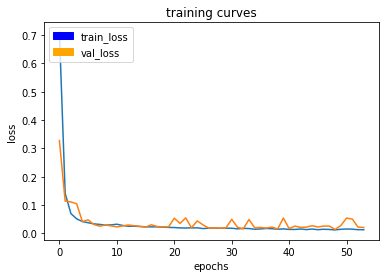

128/128 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0213
Epoch 55/120
127/128 [============================>.] - ETA: 0s - loss: 0.0139

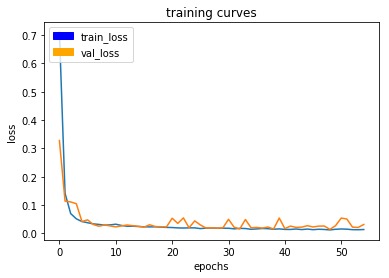

128/128 [==============================] - 72s - loss: 0.0139 - val_loss: 0.0318
Epoch 56/120
127/128 [============================>.] - ETA: 0s - loss: 0.0145

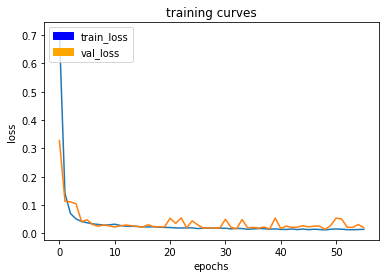

128/128 [==============================] - 72s - loss: 0.0145 - val_loss: 0.0205
Epoch 57/120
127/128 [============================>.] - ETA: 0s - loss: 0.0133

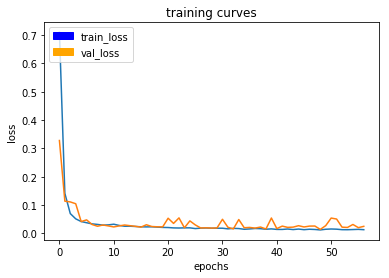

128/128 [==============================] - 73s - loss: 0.0133 - val_loss: 0.0251
Epoch 58/120
127/128 [============================>.] - ETA: 0s - loss: 0.0139

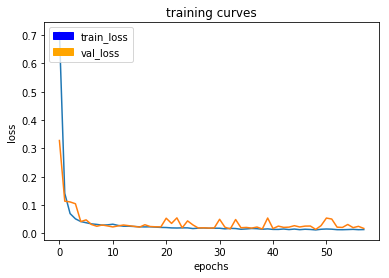

128/128 [==============================] - 72s - loss: 0.0138 - val_loss: 0.0178
Epoch 59/120
127/128 [============================>.] - ETA: 0s - loss: 0.0131

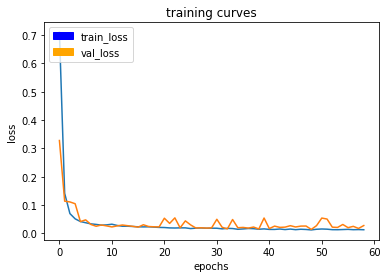

128/128 [==============================] - 73s - loss: 0.0131 - val_loss: 0.0280
Epoch 60/120
127/128 [============================>.] - ETA: 0s - loss: 0.0125

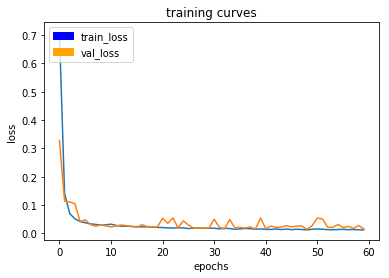

128/128 [==============================] - 72s - loss: 0.0125 - val_loss: 0.0160
Epoch 61/120
127/128 [============================>.] - ETA: 0s - loss: 0.0116

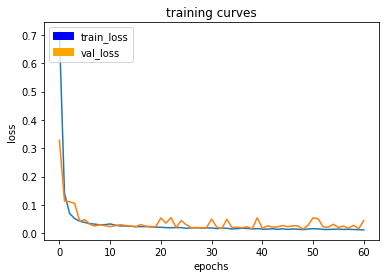

128/128 [==============================] - 72s - loss: 0.0116 - val_loss: 0.0447
Epoch 62/120
127/128 [============================>.] - ETA: 0s - loss: 0.0115

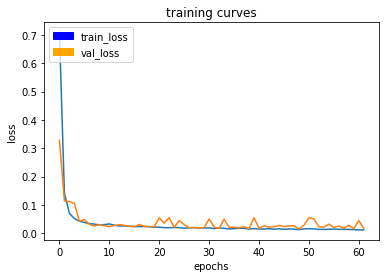

128/128 [==============================] - 72s - loss: 0.0115 - val_loss: 0.0175
Epoch 63/120
127/128 [============================>.] - ETA: 0s - loss: 0.0115

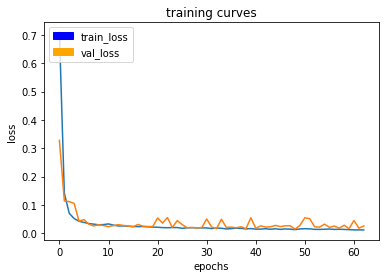

128/128 [==============================] - 72s - loss: 0.0115 - val_loss: 0.0255
Epoch 64/120
127/128 [============================>.] - ETA: 0s - loss: 0.0112

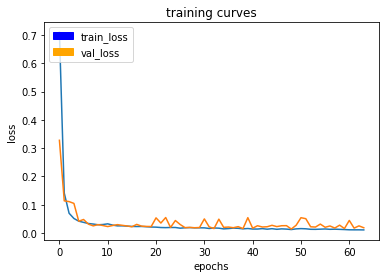

128/128 [==============================] - 72s - loss: 0.0112 - val_loss: 0.0188
Epoch 65/120
127/128 [============================>.] - ETA: 0s - loss: 0.0111

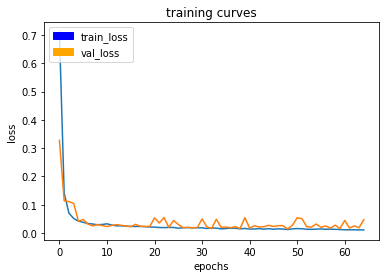

128/128 [==============================] - 72s - loss: 0.0111 - val_loss: 0.0473
Epoch 66/120
127/128 [============================>.] - ETA: 0s - loss: 0.0113

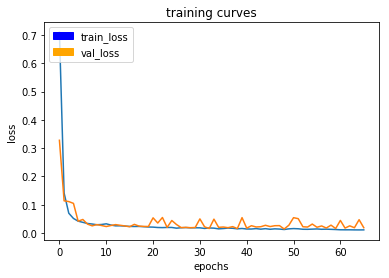

128/128 [==============================] - 72s - loss: 0.0112 - val_loss: 0.0188
Epoch 67/120
127/128 [============================>.] - ETA: 0s - loss: 0.0116

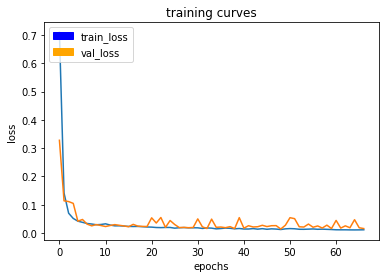

128/128 [==============================] - 73s - loss: 0.0116 - val_loss: 0.0159
Epoch 68/120
127/128 [============================>.] - ETA: 0s - loss: 0.0108

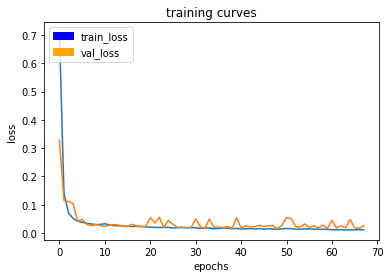

128/128 [==============================] - 72s - loss: 0.0108 - val_loss: 0.0263
Epoch 69/120
127/128 [============================>.] - ETA: 0s - loss: 0.0130

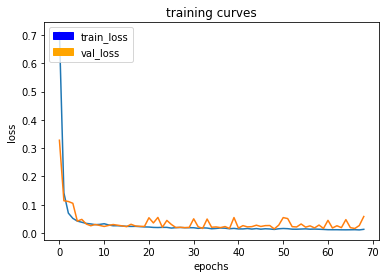

128/128 [==============================] - 72s - loss: 0.0130 - val_loss: 0.0582
Epoch 70/120
127/128 [============================>.] - ETA: 0s - loss: 0.0154

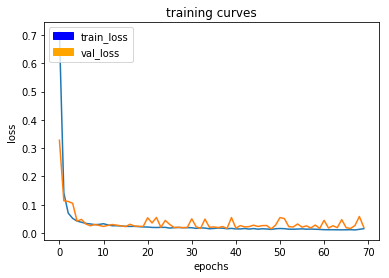

128/128 [==============================] - 72s - loss: 0.0154 - val_loss: 0.0200
Epoch 71/120
127/128 [============================>.] - ETA: 0s - loss: 0.0121

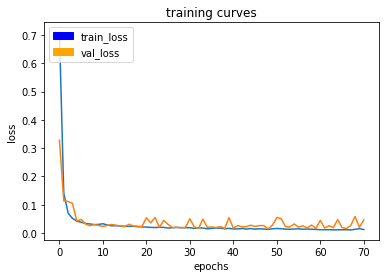

128/128 [==============================] - 72s - loss: 0.0121 - val_loss: 0.0462
Epoch 72/120
127/128 [============================>.] - ETA: 0s - loss: 0.0132

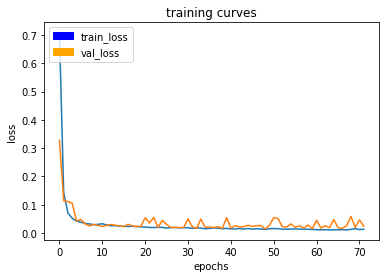

128/128 [==============================] - 72s - loss: 0.0131 - val_loss: 0.0240
Epoch 73/120
127/128 [============================>.] - ETA: 0s - loss: 0.0113

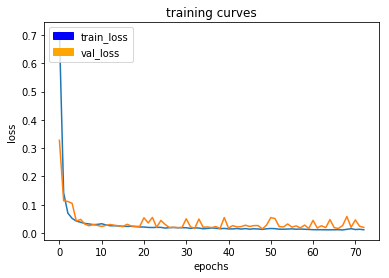

128/128 [==============================] - 72s - loss: 0.0113 - val_loss: 0.0196
Epoch 74/120
127/128 [============================>.] - ETA: 0s - loss: 0.0120

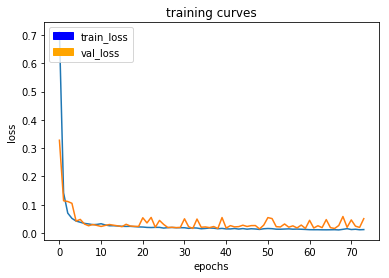

128/128 [==============================] - 73s - loss: 0.0120 - val_loss: 0.0506
Epoch 75/120
127/128 [============================>.] - ETA: 0s - loss: 0.0118

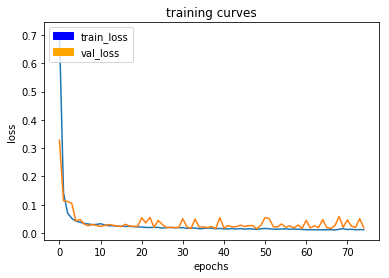

128/128 [==============================] - 72s - loss: 0.0117 - val_loss: 0.0187
Epoch 76/120
127/128 [============================>.] - ETA: 0s - loss: 0.0112

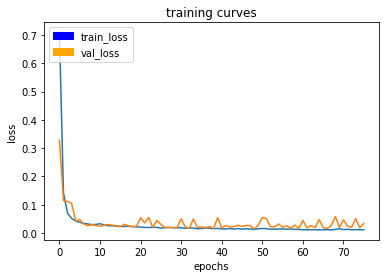

128/128 [==============================] - 72s - loss: 0.0112 - val_loss: 0.0334
Epoch 77/120
127/128 [============================>.] - ETA: 0s - loss: 0.0108

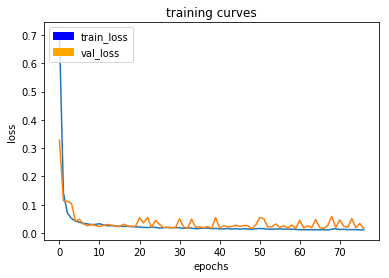

128/128 [==============================] - 72s - loss: 0.0108 - val_loss: 0.0156
Epoch 78/120
127/128 [============================>.] - ETA: 0s - loss: 0.0134

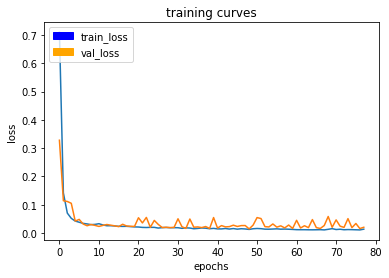

128/128 [==============================] - 72s - loss: 0.0134 - val_loss: 0.0201
Epoch 79/120
127/128 [============================>.] - ETA: 0s - loss: 0.0130

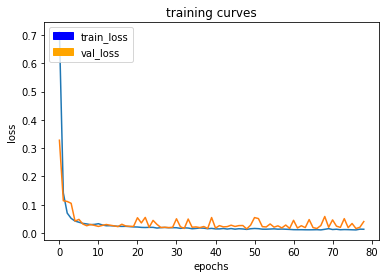

128/128 [==============================] - 72s - loss: 0.0131 - val_loss: 0.0403
Epoch 80/120
127/128 [============================>.] - ETA: 0s - loss: 0.0136

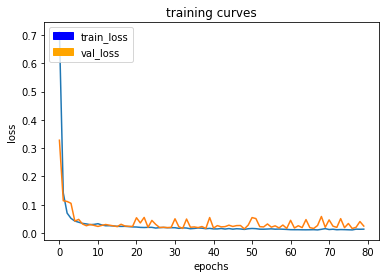

128/128 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0243
Epoch 81/120
127/128 [============================>.] - ETA: 0s - loss: 0.0115

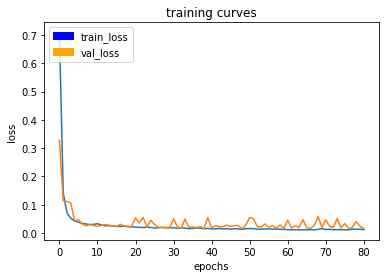

128/128 [==============================] - 72s - loss: 0.0115 - val_loss: 0.0162
Epoch 82/120
127/128 [============================>.] - ETA: 0s - loss: 0.0105

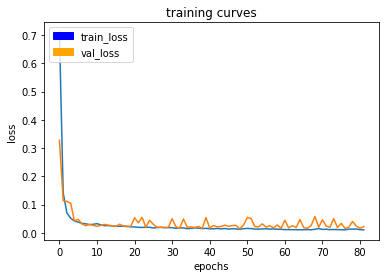

128/128 [==============================] - 73s - loss: 0.0105 - val_loss: 0.0222
Epoch 83/120
127/128 [============================>.] - ETA: 0s - loss: 0.0143

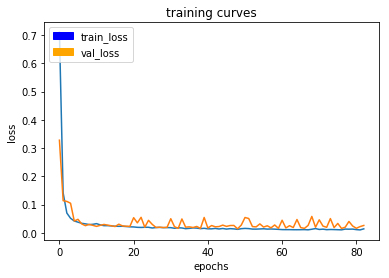

128/128 [==============================] - 72s - loss: 0.0143 - val_loss: 0.0263
Epoch 84/120
127/128 [============================>.] - ETA: 0s - loss: 0.0111

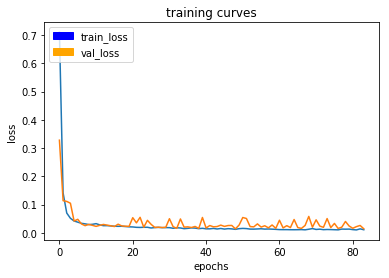

128/128 [==============================] - 73s - loss: 0.0111 - val_loss: 0.0145
Epoch 85/120
127/128 [============================>.] - ETA: 0s - loss: 0.0111

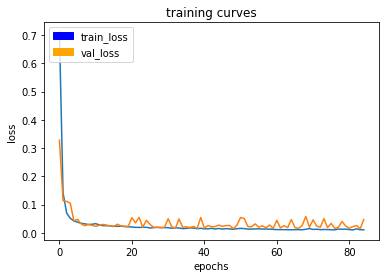

128/128 [==============================] - 72s - loss: 0.0111 - val_loss: 0.0473
Epoch 86/120
127/128 [============================>.] - ETA: 0s - loss: 0.0116

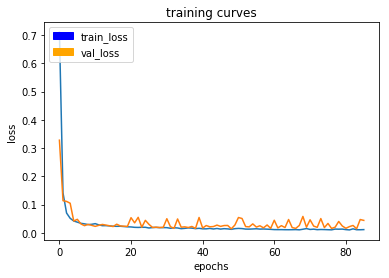

128/128 [==============================] - 72s - loss: 0.0116 - val_loss: 0.0442
Epoch 87/120
127/128 [============================>.] - ETA: 0s - loss: 0.0120

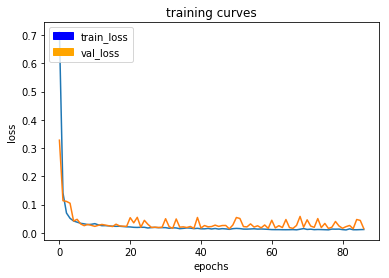

128/128 [==============================] - 72s - loss: 0.0120 - val_loss: 0.0150
Epoch 88/120
127/128 [============================>.] - ETA: 0s - loss: 0.0110

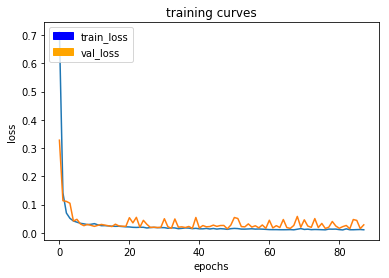

128/128 [==============================] - 72s - loss: 0.0110 - val_loss: 0.0284
Epoch 89/120
127/128 [============================>.] - ETA: 0s - loss: 0.0112

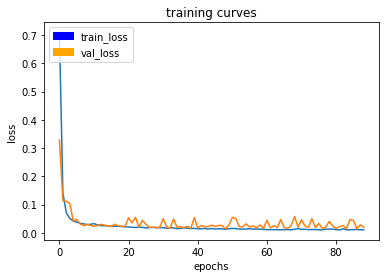

128/128 [==============================] - 72s - loss: 0.0112 - val_loss: 0.0198
Epoch 90/120
127/128 [============================>.] - ETA: 0s - loss: 0.0127

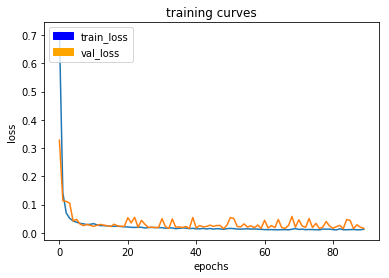

128/128 [==============================] - 72s - loss: 0.0127 - val_loss: 0.0162
Epoch 91/120
127/128 [============================>.] - ETA: 0s - loss: 0.0121

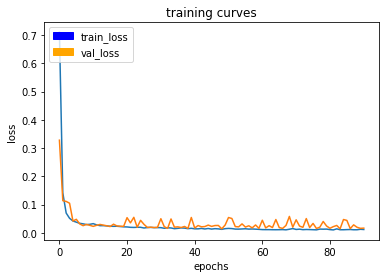

128/128 [==============================] - 72s - loss: 0.0121 - val_loss: 0.0168
Epoch 92/120
127/128 [============================>.] - ETA: 0s - loss: 0.0114

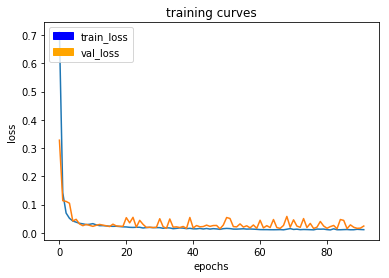

128/128 [==============================] - 73s - loss: 0.0114 - val_loss: 0.0242
Epoch 93/120
127/128 [============================>.] - ETA: 0s - loss: 0.0109

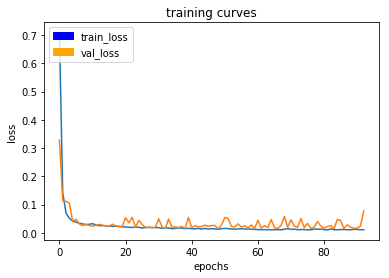

128/128 [==============================] - 72s - loss: 0.0109 - val_loss: 0.0775
Epoch 94/120
127/128 [============================>.] - ETA: 0s - loss: 0.0100

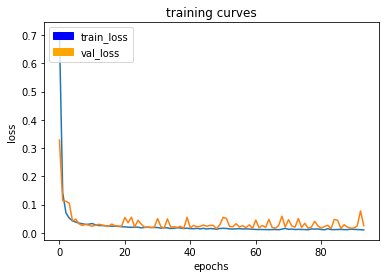

128/128 [==============================] - 72s - loss: 0.0100 - val_loss: 0.0252
Epoch 95/120
127/128 [============================>.] - ETA: 0s - loss: 0.0099

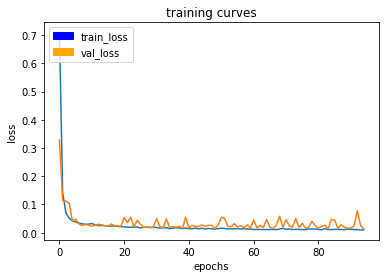

128/128 [==============================] - 72s - loss: 0.0099 - val_loss: 0.0137
Epoch 96/120
127/128 [============================>.] - ETA: 0s - loss: 0.0121

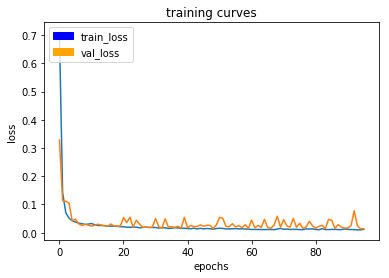

128/128 [==============================] - 72s - loss: 0.0122 - val_loss: 0.0141
Epoch 97/120
127/128 [============================>.] - ETA: 0s - loss: 0.0106

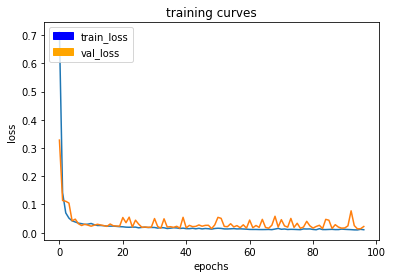

128/128 [==============================] - 73s - loss: 0.0106 - val_loss: 0.0220
Epoch 98/120
127/128 [============================>.] - ETA: 0s - loss: 0.0100

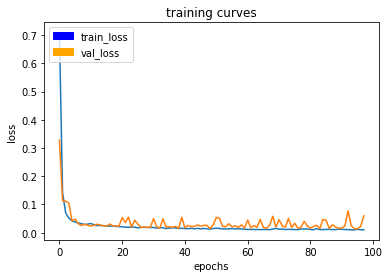

128/128 [==============================] - 72s - loss: 0.0099 - val_loss: 0.0598
Epoch 99/120
127/128 [============================>.] - ETA: 0s - loss: 0.0097

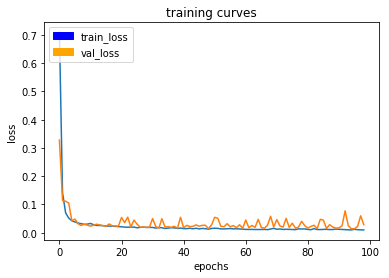

128/128 [==============================] - 72s - loss: 0.0097 - val_loss: 0.0281
Epoch 100/120
127/128 [============================>.] - ETA: 0s - loss: 0.0096

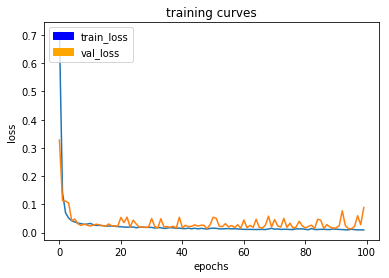

128/128 [==============================] - 72s - loss: 0.0096 - val_loss: 0.0889
Epoch 101/120
127/128 [============================>.] - ETA: 0s - loss: 0.0094

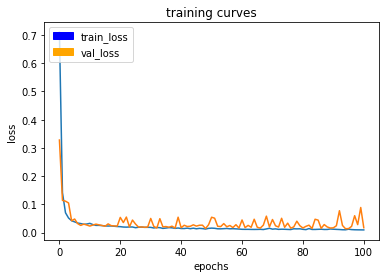

128/128 [==============================] - 72s - loss: 0.0094 - val_loss: 0.0172
Epoch 102/120
127/128 [============================>.] - ETA: 0s - loss: 0.0099

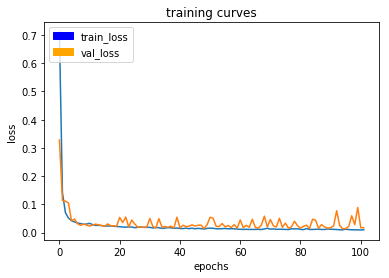

128/128 [==============================] - 72s - loss: 0.0099 - val_loss: 0.0172
Epoch 103/120
127/128 [============================>.] - ETA: 0s - loss: 0.0096

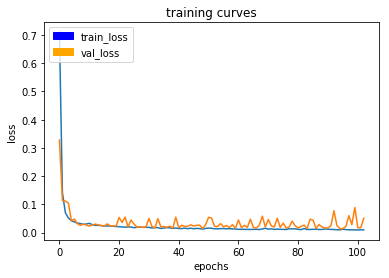

128/128 [==============================] - 72s - loss: 0.0096 - val_loss: 0.0508
Epoch 104/120
127/128 [============================>.] - ETA: 0s - loss: 0.0175

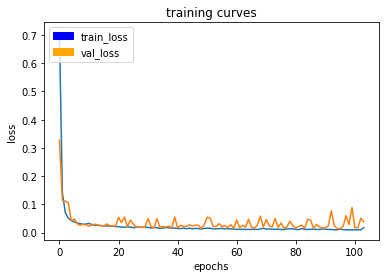

128/128 [==============================] - 72s - loss: 0.0175 - val_loss: 0.0384
Epoch 105/120
127/128 [============================>.] - ETA: 0s - loss: 0.0124

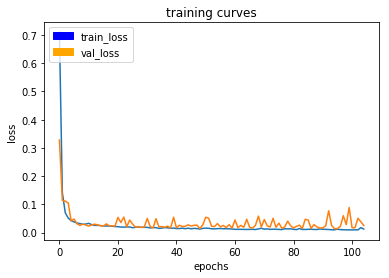

128/128 [==============================] - 72s - loss: 0.0123 - val_loss: 0.0247
Epoch 106/120
127/128 [============================>.] - ETA: 0s - loss: 0.0114

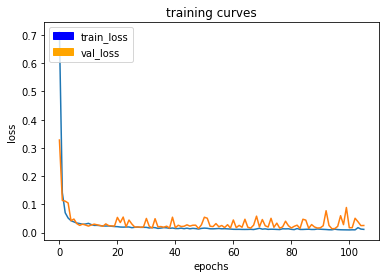

128/128 [==============================] - 72s - loss: 0.0114 - val_loss: 0.0251
Epoch 107/120
127/128 [============================>.] - ETA: 0s - loss: 0.0105

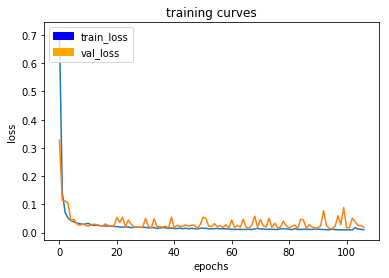

128/128 [==============================] - 72s - loss: 0.0105 - val_loss: 0.0190
Epoch 108/120
127/128 [============================>.] - ETA: 0s - loss: 0.0103

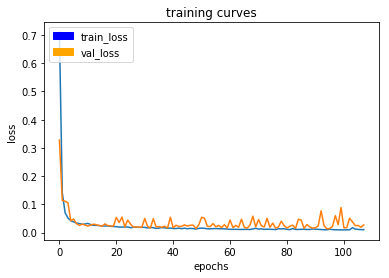

128/128 [==============================] - 72s - loss: 0.0103 - val_loss: 0.0271
Epoch 109/120
127/128 [============================>.] - ETA: 0s - loss: 0.0114

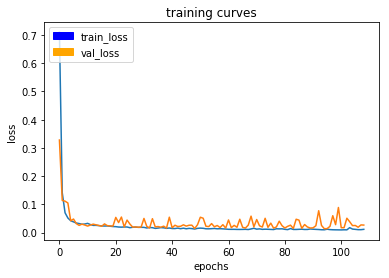

128/128 [==============================] - 73s - loss: 0.0114 - val_loss: 0.0266
Epoch 110/120
127/128 [============================>.] - ETA: 0s - loss: 0.0101

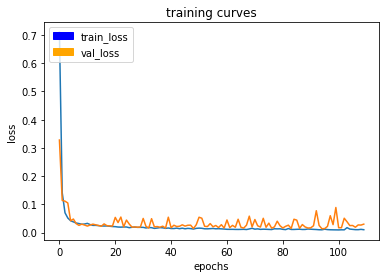

128/128 [==============================] - 72s - loss: 0.0101 - val_loss: 0.0299
Epoch 111/120
127/128 [============================>.] - ETA: 0s - loss: 0.0101

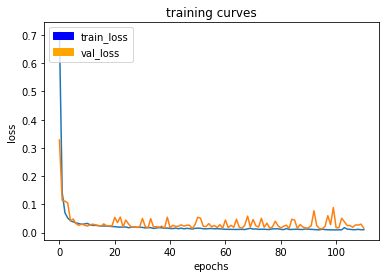

128/128 [==============================] - 73s - loss: 0.0101 - val_loss: 0.0153
Epoch 112/120
127/128 [============================>.] - ETA: 0s - loss: 0.0101

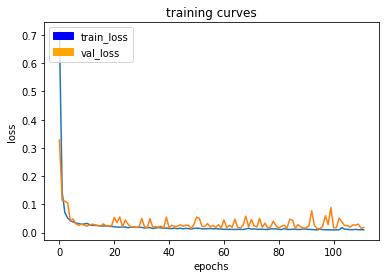

128/128 [==============================] - 73s - loss: 0.0101 - val_loss: 0.0178
Epoch 113/120
127/128 [============================>.] - ETA: 0s - loss: 0.0101

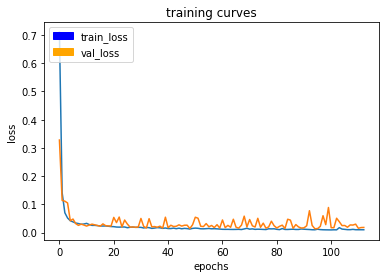

128/128 [==============================] - 72s - loss: 0.0100 - val_loss: 0.0182
Epoch 114/120
127/128 [============================>.] - ETA: 0s - loss: 0.0099

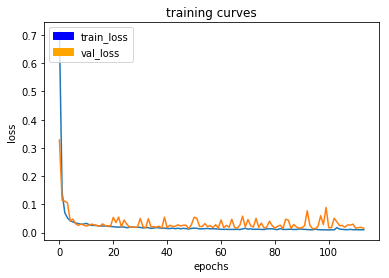

128/128 [==============================] - 72s - loss: 0.0099 - val_loss: 0.0156
Epoch 115/120
127/128 [============================>.] - ETA: 0s - loss: 0.0096

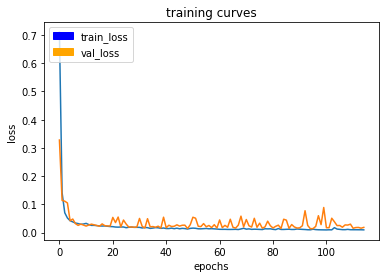

128/128 [==============================] - 72s - loss: 0.0096 - val_loss: 0.0184
Epoch 116/120
127/128 [============================>.] - ETA: 0s - loss: 0.0094

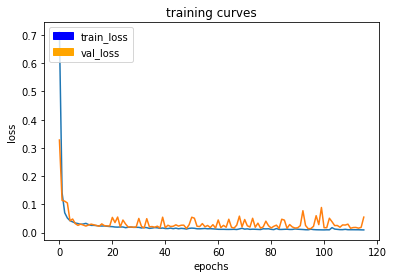

128/128 [==============================] - 72s - loss: 0.0094 - val_loss: 0.0547
Epoch 117/120
127/128 [============================>.] - ETA: 0s - loss: 0.0097

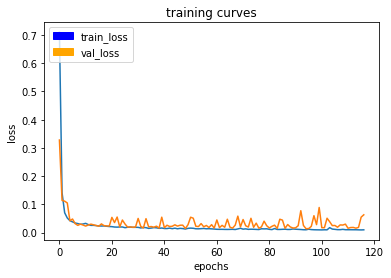

128/128 [==============================] - 72s - loss: 0.0097 - val_loss: 0.0629
Epoch 118/120
127/128 [============================>.] - ETA: 0s - loss: 0.0092

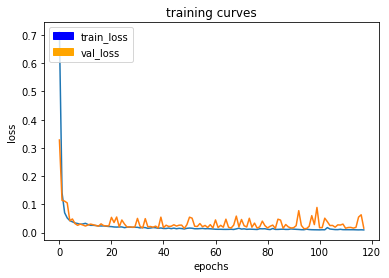

128/128 [==============================] - 72s - loss: 0.0092 - val_loss: 0.0155
Epoch 119/120
127/128 [============================>.] - ETA: 0s - loss: 0.0094

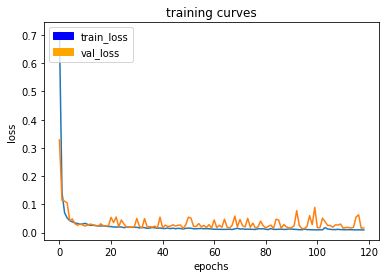

128/128 [==============================] - 72s - loss: 0.0094 - val_loss: 0.0163
Epoch 120/120
127/128 [============================>.] - ETA: 0s - loss: 0.0096

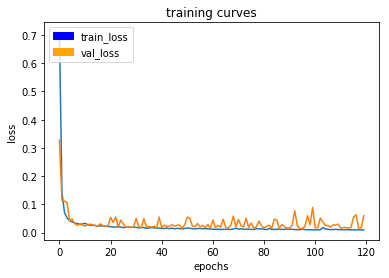

128/128 [==============================] - 72s - loss: 0.0096 - val_loss: 0.0596


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

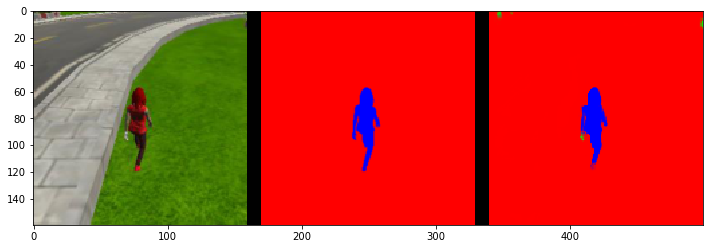

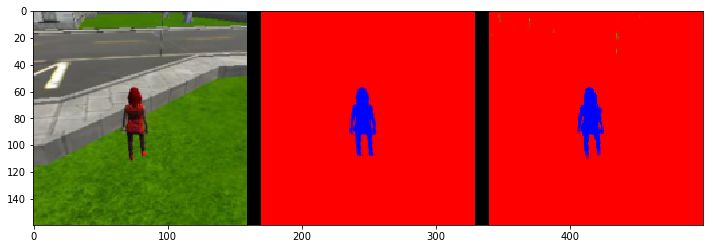

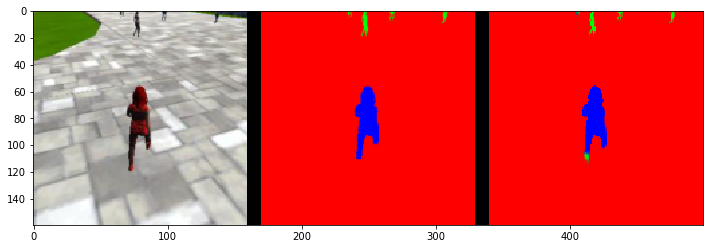

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

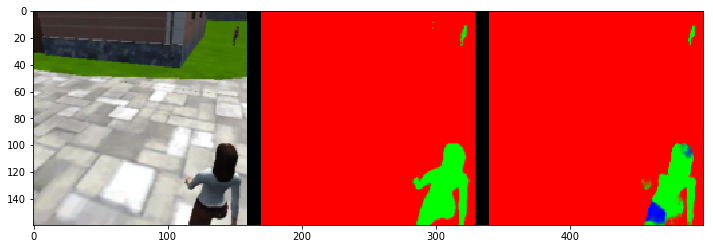

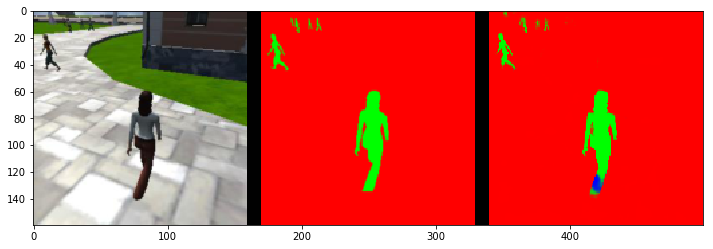

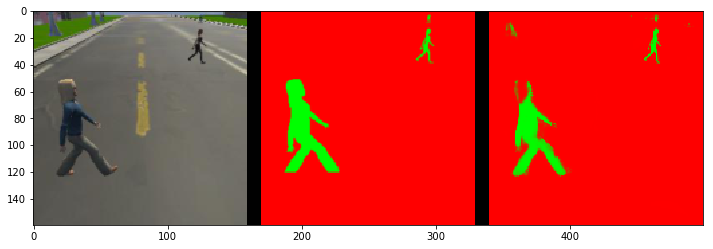

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

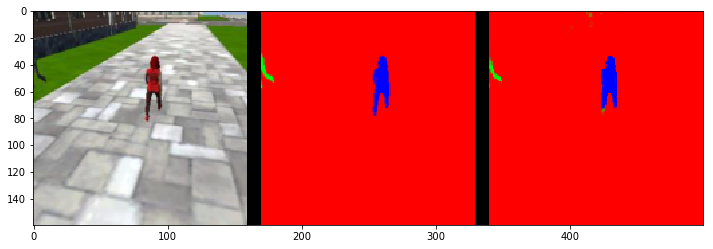

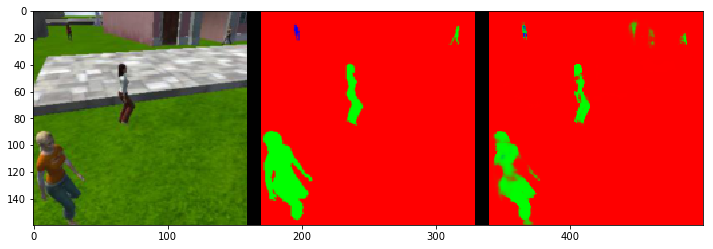

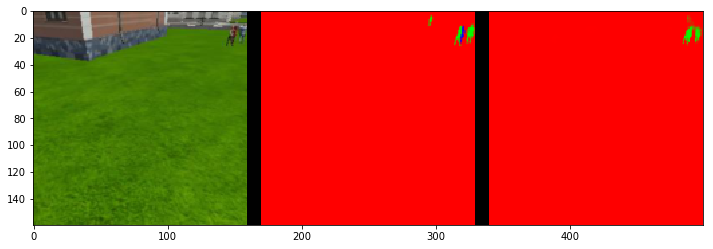

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9956285797142593
average intersection over union for other people is 0.36739350451604763
average intersection over union for the hero is 0.9059961915723319
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9885152093541548
average intersection over union for other people is 0.7690970778245004
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 67, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9965892969637136
average intersection over union for other people is 0.4535834472573215
average intersection over union for the hero is 0.21909812664499526
number true positives: 128, number false positives: 2, number false negatives: 173


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7337733773377337


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.562547159109


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.412782128851
